In [2]:
# === Final Code for Table 1 Generation ===
import os
import pandas as pd
import numpy as np
from tabulate import tabulate

# Load splits
train_df = pd.read_csv("unitochest_train_dataset_dicom_metadata.csv")
val_df = pd.read_csv("unitochest_val_dataset_dicom_metadata.csv")
test_df = pd.read_csv("unitochest_test_dataset_dicom_metadata.csv")

# Label splits
train_df["Split"] = "Train"
val_df["Split"] = "Validation"
test_df["Split"] = "Test"

# Combine
combined_df = pd.concat([train_df, val_df, test_df], ignore_index=True)
combined_df["PatientAgeYears"] = pd.to_numeric(combined_df["PatientAge"].str.extract(r"(\d+)")[0], errors="coerce")

# Totals
n_train = (combined_df["Split"] == "Train").sum()
n_val = (combined_df["Split"] == "Validation").sum()
n_test = (combined_df["Split"] == "Test").sum()
n_total = len(combined_df)

# Helper to format count + percentage
def count_pct(val, denom):
    return f"{val} ({(val / denom * 100):.1f}%)"

# Build table
final_rows = []

# Age stats
mean_age = combined_df.groupby("Split")["PatientAgeYears"].mean().round(1)
std_age = combined_df.groupby("Split")["PatientAgeYears"].std().round(1)
age_min = combined_df.groupby("Split")["PatientAgeYears"].min().fillna(0).astype(int)
age_max = combined_df.groupby("Split")["PatientAgeYears"].max().fillna(0).astype(int)

final_rows.append(["Age (years)", "Mean ± SD",
                   f"{mean_age.mean():.1f} ± {std_age.mean():.1f}",
                   f"{mean_age['Train']:.1f} ± {std_age['Train']:.1f}",
                   f"{mean_age['Validation']:.1f} ± {std_age['Validation']:.1f}",
                   f"{mean_age['Test']:.1f} ± {std_age['Test']:.1f}"])

final_rows.append(["Age (years)", "Range",
                   f"{int(combined_df['PatientAgeYears'].min())}–{int(combined_df['PatientAgeYears'].max())}",
                   f"{age_min['Train']}–{age_max['Train']}",
                   f"{age_min['Validation']}–{age_max['Validation']}",
                   f"{age_min['Test']}–{age_max['Test']}"])

# Gender
for gender in ["F", "M"]:
    label = "Female" if gender == "F" else "Male"
    row = ["Gender", label]
    for split, n in zip(["Total", "Train", "Validation", "Test"], [n_total, n_train, n_val, n_test]):
        count = (combined_df[(combined_df["Split"] == split) & (combined_df["PatientSex"] == gender)]
                 if split != "Total" else combined_df[combined_df["PatientSex"] == gender]).shape[0]
        row.append(count_pct(count, n))
    final_rows.append(row)

# Manufacturer
for manu in ["GE MEDICAL SYSTEMS", "Philips"]:
    row = ["Manufacturer", manu]
    for split, n in zip(["Total", "Train", "Validation", "Test"], [n_total, n_train, n_val, n_test]):
        count = (combined_df[(combined_df["Split"] == split) & (combined_df["Manufacturer"] == manu)]
                 if split != "Total" else combined_df[combined_df["Manufacturer"] == manu]).shape[0]
        row.append(count_pct(count, n))
    final_rows.append(row)

# Kernel
top_kernels = combined_df["ConvolutionKernel"].value_counts().nlargest(2).index
for kernel in top_kernels:
    row = ["Kernel", kernel]
    for split, n in zip(["Total", "Train", "Validation", "Test"], [n_total, n_train, n_val, n_test]):
        count = (combined_df[(combined_df["Split"] == split) & (combined_df["ConvolutionKernel"] == kernel)]
                 if split != "Total" else combined_df[combined_df["ConvolutionKernel"] == kernel]).shape[0]
        row.append(count_pct(count, n))
    final_rows.append(row)

# Patient Position
for pos in combined_df["PatientPosition"].dropna().unique():
    row = ["Patient Position", pos]
    for split, n in zip(["Total", "Train", "Validation", "Test"], [n_total, n_train, n_val, n_test]):
        count = (combined_df[(combined_df["Split"] == split) & (combined_df["PatientPosition"] == pos)]
                 if split != "Total" else combined_df[combined_df["PatientPosition"] == pos]).shape[0]
        row.append(count_pct(count, n))
    final_rows.append(row)

# Display as formatted table
headers = ["Category", "Value", f"Total\n(N = {n_total})",
           f"Train\n(n = {n_train})", f"Validation\n(n = {n_val})", f"Test\n(n = {n_test})"]
print(tabulate(final_rows, headers=headers, tablefmt="grid"))


+------------------+--------------------+-------------+-------------+--------------+-------------+
| Category         | Value              | Total       | Train       | Validation   | Test        |
|                  |                    | (N = 715)   | (n = 579)   | (n = 66)     | (n = 70)    |
+==================+====================+=============+=============+==============+=============+
| Age (years)      | Mean ± SD          | 67.0 ± 10.2 | 66.8 ± 10.9 | 68.6 ± 7.7   | 65.7 ± 12.0 |
+------------------+--------------------+-------------+-------------+--------------+-------------+
| Age (years)      | Range              | 7–91        | 7–91        | 45–87        | 12–89       |
+------------------+--------------------+-------------+-------------+--------------+-------------+
| Gender           | Female             | 286 (40.0%) | 229 (39.6%) | 25 (37.9%)   | 32 (45.7%)  |
+------------------+--------------------+-------------+-------------+--------------+-------------+
| Gender  

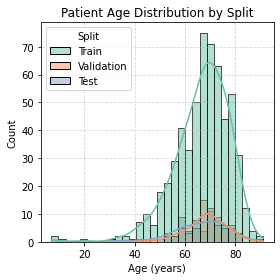

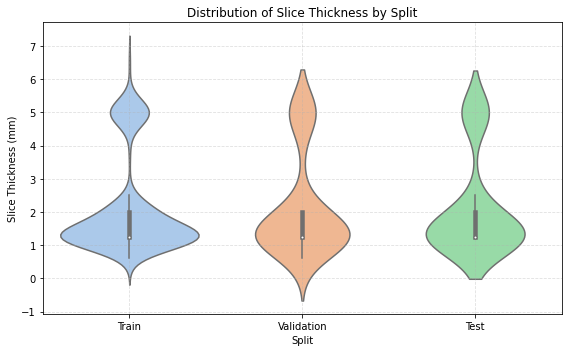

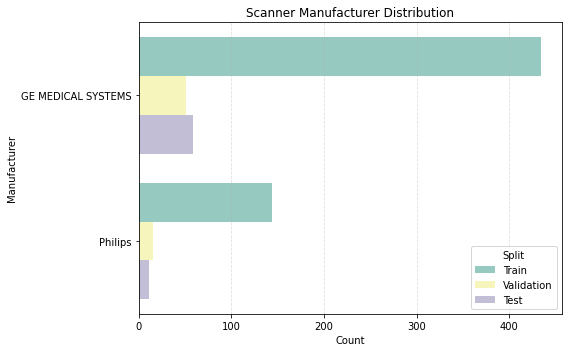

In [12]:
# === Visualization Script for UniToChest Dataset ===
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load and merge metadata
train_df = pd.read_csv("unitochest_train_dataset_dicom_metadata.csv")
val_df = pd.read_csv("unitochest_val_dataset_dicom_metadata.csv")
test_df = pd.read_csv("unitochest_test_dataset_dicom_metadata.csv")

train_df["Split"] = "Train"
val_df["Split"] = "Validation"
test_df["Split"] = "Test"

df = pd.concat([train_df, val_df, test_df], ignore_index=True)
df["PatientAgeYears"] = pd.to_numeric(df["PatientAge"].str.extract(r"(\d+)")[0], errors="coerce")
df["SliceThickness"] = pd.to_numeric(df["SliceThickness"], errors="coerce")
df["KVP"] = pd.to_numeric(df["KVP"], errors="coerce")

# === Plot 1: Age distribution ===
plt.figure(figsize=(4,4))
sns.histplot(data=df, x="PatientAgeYears", hue="Split", bins=30, kde=True, palette="Set2")
plt.title("Patient Age Distribution by Split")
plt.xlabel("Age (years)")
plt.ylabel("Count")
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.savefig("age_distribution_by_split.png")
plt.show()

# === Plot 2: Slice thickness violin ===
plt.figure(figsize=(8, 5))
sns.violinplot(data=df, x="Split", y="SliceThickness", inner="box", palette="pastel")
plt.title("Distribution of Slice Thickness by Split")
plt.ylabel("Slice Thickness (mm)")
plt.grid(True, linestyle="--", alpha=0.4)
plt.tight_layout()
plt.savefig("slice_thickness_violin.png")
plt.show()

# === Plot 4: Manufacturer bar plot ===
plt.figure(figsize=(8, 5))
sns.countplot(data=df, y="Manufacturer", hue="Split", palette="Set3")
plt.title("Scanner Manufacturer Distribution")
plt.xlabel("Count")
plt.ylabel("Manufacturer")
plt.grid(True, linestyle="--", axis='x', alpha=0.4)
plt.tight_layout()
plt.savefig("manufacturer_distribution.png")
plt.show()


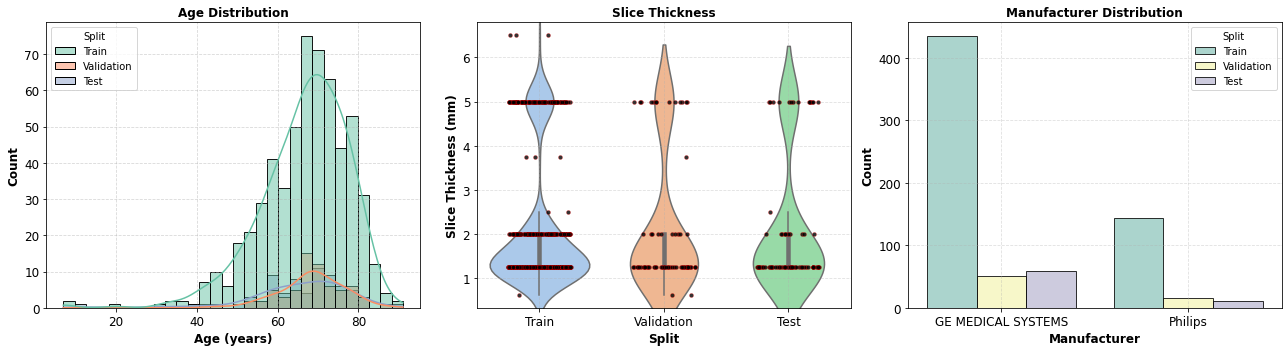

In [26]:
# === Visualization Script for UniToChest Dataset ===
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load and merge metadata
train_df = pd.read_csv("unitochest_train_dataset_dicom_metadata.csv")
val_df = pd.read_csv("unitochest_val_dataset_dicom_metadata.csv")
test_df = pd.read_csv("unitochest_test_dataset_dicom_metadata.csv")

train_df["Split"] = "Train"
val_df["Split"] = "Validation"
test_df["Split"] = "Test"

df = pd.concat([train_df, val_df, test_df], ignore_index=True)
df["PatientAgeYears"] = pd.to_numeric(df["PatientAge"].str.extract(r"(\d+)")[0], errors="coerce")
df["SliceThickness"] = pd.to_numeric(df["SliceThickness"], errors="coerce")

# === Create 3-subplot figure ===
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot 1: Age Distribution
sns.histplot(data=df, x="PatientAgeYears", hue="Split", bins=30, kde=True, palette="Set2", ax=axes[0])
axes[0].set_title("Age Distribution", fontsize=12, fontweight='bold')
axes[0].set_xlabel("Age (years)", fontsize=12, fontweight='bold')
axes[0].set_ylabel("Count", fontsize=12, fontweight='bold')
axes[0].tick_params(labelsize=12)
axes[0].grid(True, linestyle="--", alpha=0.5)

# Plot 2: Slice Thickness
sns.violinplot(data=df, x="Split", y="SliceThickness", inner="box", palette="pastel", ax=axes[1])
sns.stripplot(data=df, x="Split", y="SliceThickness", color='black', jitter=0.25, alpha=0.8, size=4,edgecolor="red", linewidth=0.3,ax=axes[1])
axes[1].set_title("Slice Thickness", fontsize=12, fontweight='bold')
axes[1].set_ylabel("Slice Thickness (mm)", fontsize=12, fontweight='bold')
axes[1].set_xlabel("Split", fontsize=12, fontweight='bold')
axes[1].tick_params(labelsize=12)
axes[1].grid(True, linestyle="--", alpha=0.4)

# Plot 3: Manufacturer Count Plot
sns.countplot(data=df, x="Manufacturer", hue="Split", palette="Set3", ax=axes[2],alpha=0.8,edgecolor='black')
axes[2].set_title("Manufacturer Distribution", fontsize=12, fontweight='bold')
axes[2].set_xlabel("Manufacturer", fontsize=12, fontweight='bold')
axes[2].set_ylabel("Count", fontsize=12, fontweight='bold')
axes[2].tick_params(axis='x', rotation=0, labelsize=12)
axes[2].tick_params(axis='y', labelsize=12)
axes[2].grid(True, linestyle="--", alpha=0.4)

plt.tight_layout()
plt.savefig("unitochest_clinical_subplots.png",dpi=300)
plt.show()

In [28]:
# Re-import after reset
import pandas as pd

# Reload DICOM metadata
train_df = pd.read_csv("unitochest_train_dataset_dicom_metadata.csv")
val_df = pd.read_csv("unitochest_val_dataset_dicom_metadata.csv")
test_df = pd.read_csv("unitochest_test_dataset_dicom_metadata.csv")

# Assign split
train_df["Split"] = "Train"
val_df["Split"] = "Validation"
test_df["Split"] = "Test"

# Combine
df = pd.concat([train_df, val_df, test_df], ignore_index=True)

# Count unique patients
patient_counts = df.groupby("Split")["PatientID"].nunique().to_dict()
patient_counts["Total"] = df["PatientID"].nunique()
patient_counts


{'Test': 63, 'Train': 501, 'Validation': 62, 'Total': 626}

In [30]:
# === Final Code for Table 1 Generation ===
import os
import pandas as pd
import numpy as np
from tabulate import tabulate

# Load splits
train_df = pd.read_csv("unitochest_train_dataset_dicom_metadata.csv")
val_df = pd.read_csv("unitochest_val_dataset_dicom_metadata.csv")
test_df = pd.read_csv("unitochest_test_dataset_dicom_metadata.csv")

# Label splits
train_df["Split"] = "Train"
val_df["Split"] = "Validation"
test_df["Split"] = "Test"

# Combine
combined_df = pd.concat([train_df, val_df, test_df], ignore_index=True)
combined_df["PatientAgeYears"] = pd.to_numeric(combined_df["PatientAge"].str.extract(r"(\d+)")[0], errors="coerce")

# Count unique patients
n_train = train_df["PatientID"].nunique()
n_val = val_df["PatientID"].nunique()
n_test = test_df["PatientID"].nunique()
n_total = combined_df["PatientID"].nunique()

# Helper to format count + percentage
def count_pct(val, denom):
    return f"{val} ({(val / denom * 100):.1f}%)"

# Build table
final_rows = []

# Patient counts
final_rows.append(["Patient Count", "Unique Patients",
                   count_pct(n_total, n_total),
                   count_pct(n_train, n_total),
                   count_pct(n_val, n_total),
                   count_pct(n_test, n_total)])

# Age stats
mean_age = combined_df.groupby("Split")["PatientAgeYears"].mean().round(1)
std_age = combined_df.groupby("Split")["PatientAgeYears"].std().round(1)
age_min = combined_df.groupby("Split")["PatientAgeYears"].min().fillna(0).astype(int)
age_max = combined_df.groupby("Split")["PatientAgeYears"].max().fillna(0).astype(int)

final_rows.append(["Age (years)", "Mean ± SD",
                   f"{mean_age.mean():.1f} ± {std_age.mean():.1f}",
                   f"{mean_age['Train']:.1f} ± {std_age['Train']:.1f}",
                   f"{mean_age['Validation']:.1f} ± {std_age['Validation']:.1f}",
                   f"{mean_age['Test']:.1f} ± {std_age['Test']:.1f}"])

final_rows.append(["Age (years)", "Range",
                   f"{int(combined_df['PatientAgeYears'].min())}–{int(combined_df['PatientAgeYears'].max())}",
                   f"{age_min['Train']}–{age_max['Train']}",
                   f"{age_min['Validation']}–{age_max['Validation']}",
                   f"{age_min['Test']}–{age_max['Test']}"])

# Gender
for gender in ["F", "M"]:
    label = "Female" if gender == "F" else "Male"
    row = ["Gender", label]
    for split, n in zip(["Total", "Train", "Validation", "Test"], [n_total, n_train, n_val, n_test]):
        count = (combined_df[(combined_df["Split"] == split) & (combined_df["PatientSex"] == gender)]
                 if split != "Total" else combined_df[combined_df["PatientSex"] == gender]).shape[0]
        row.append(count_pct(count, n))
    final_rows.append(row)

# Manufacturer
for manu in ["GE MEDICAL SYSTEMS", "Philips"]:
    row = ["Manufacturer", manu]
    for split, n in zip(["Total", "Train", "Validation", "Test"], [n_total, n_train, n_val, n_test]):
        count = (combined_df[(combined_df["Split"] == split) & (combined_df["Manufacturer"] == manu)]
                 if split != "Total" else combined_df[combined_df["Manufacturer"] == manu]).shape[0]
        row.append(count_pct(count, n))
    final_rows.append(row)

# Kernel
top_kernels = combined_df["ConvolutionKernel"].value_counts().nlargest(2).index
for kernel in top_kernels:
    row = ["Kernel", kernel]
    for split, n in zip(["Total", "Train", "Validation", "Test"], [n_total, n_train, n_val, n_test]):
        count = (combined_df[(combined_df["Split"] == split) & (combined_df["ConvolutionKernel"] == kernel)]
                 if split != "Total" else combined_df[combined_df["ConvolutionKernel"] == kernel]).shape[0]
        row.append(count_pct(count, n))
    final_rows.append(row)

# Patient Position
for pos in combined_df["PatientPosition"].dropna().unique():
    row = ["Patient Position", pos]
    for split, n in zip(["Total", "Train", "Validation", "Test"], [n_total, n_train, n_val, n_test]):
        count = (combined_df[(combined_df["Split"] == split) & (combined_df["PatientPosition"] == pos)]
                 if split != "Total" else combined_df[combined_df["PatientPosition"] == pos]).shape[0]
        row.append(count_pct(count, n))
    final_rows.append(row)

# Display as formatted table
headers = ["Category", "Value", f"Total\n(N = {n_total})",
           f"Train\n(n = {n_train})", f"Validation\n(n = {n_val})", f"Test\n(n = {n_test})"]
print(tabulate(final_rows, headers=headers, tablefmt="grid"))


+------------------+--------------------+--------------+-------------+--------------+-------------+
| Category         | Value              | Total        | Train       | Validation   | Test        |
|                  |                    | (N = 626)    | (n = 501)   | (n = 62)     | (n = 63)    |
+==================+====================+==============+=============+==============+=============+
| Patient Count    | Unique Patients    | 626 (100.0%) | 501 (80.0%) | 62 (9.9%)    | 63 (10.1%)  |
+------------------+--------------------+--------------+-------------+--------------+-------------+
| Age (years)      | Mean ± SD          | 67.0 ± 10.2  | 66.8 ± 10.9 | 68.6 ± 7.7   | 65.7 ± 12.0 |
+------------------+--------------------+--------------+-------------+--------------+-------------+
| Age (years)      | Range              | 7–91         | 7–91        | 45–87        | 12–89       |
+------------------+--------------------+--------------+-------------+--------------+-------------+


,patientID,exam,nifti_filename,PatientName,PatientID,PatientSex,PatientAge,PatientBirthDate,StudyDate,StudyTime,...,KVP,FilterType,PatientPosition,WindowCenter,WindowWidth,RescaleIntercept,RescaleSlope,SoftwareVersions,Split,PatientAgeYears
0,1,1,unitochestPT1_exam1_0000.nii.gz,ANON20190923012,ANON20190923012,M,078Y,19380304,20160421,111228,...,120.0,MEDIUM FILTER,FFS,40,400,-1024.0,1.0,revo_1.5_m3a.46,Train,78
1,2,1,unitochestPT2_exam1_0000.nii.gz,ANON20190923016,ANON20190923016,M,068Y,19490420,20170711,114343,...,120.0,L,HFS,"[-0600, -0600]","[01600, 01600]",-1024.0,1.0,2.3.0,Train,68
2,6,1,unitochestPT6_exam1_0000.nii.gz,ANON201909230113,ANON201909230113,F,065Y,19530102,20180925,151249,...,120.0,BODY FILTER,HFS,40,400,-1024.0,1.0,cj_kl.17,Train,65
3,7,1,unitochestPT7_exam1_0000.nii.gz,ANON20190924012,ANON20190924012,M,074Y,19440607,20190606,115418,...,120.0,B,HFS,"[00040, 00040]","[00400, 00400]",-1024.0,1.0,2.3.0,Train,74
4,8,1,unitochestPT8_exam1_0000.nii.gz,ANON20190924014,ANON20190924014,F,059Y,19570129,20160603,84247,...,120.0,BODY FILTER,FFS,40,400,-1024.0,1.0,revo_1.5_m3a.46,Train,59
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
710,1653,1,unitochestPT1653_exam1_0000.nii.gz,deephealth_molinette_1653,deephealth_molinette_1653,F,069Y,19481130,20180327,80607,...,120.0,BODY FILTER,FFS,60,400,-1024.0,1.0,cj_kl.17,Test,69
711,1742,1,unitochestPT1742_exam1_0000.nii.gz,deephealth_molinette_1742_e1,deephealth_molinette_1742_e1,M,070Y,19500831,20200924,123143,...,120.0,BODY FILTER,HFS,-600,1600,-1024.0,1.0,cj3_6m3a_qr.11,Test,70
712,1812,1,unitochestPT1812_exam1_0000.nii.gz,deephealth_molinette_1812_e1,deephealth_molinette_1812_e1,F,066Y,19491120,20160503,85631,...,120.0,BODY FILTER,HFS,60,400,-1024.0,1.0,cj_kl.17,Test,66
713,1833,1,unitochestPT1833_exam1_0000.nii.gz,deephealth_molinette_1833_e1,deephealth_molinette_1833_e1,F,012Y,20040523,20161031,95538,...,100.0,HEAD FILTER,HFS,40,400,-1024.0,1.0,07MW18.4,Test,12


# Annotations and Demographics

In [40]:
# === Final Code for Table 1 Generation ===
import os
import pandas as pd
import numpy as np
from tabulate import tabulate

# Load splits
train_df = pd.read_csv("unitochest_train_dataset_dicom_metadata.csv")
val_df = pd.read_csv("unitochest_val_dataset_dicom_metadata.csv")
test_df = pd.read_csv("unitochest_test_dataset_dicom_metadata.csv")

# Label splits
train_df["Split"] = "Train"
val_df["Split"] = "Validation"
test_df["Split"] = "Test"

# Combine
combined_df = pd.concat([train_df, val_df, test_df], ignore_index=True)
combined_df["PatientAgeYears"] = pd.to_numeric(combined_df["PatientAge"].str.extract(r"(\d+)")[0], errors="coerce")


combined_df
Filtered_3D_Annotations = pd.read_csv('filtered_unitochest_bounding_boxes_annotations.csv')
Filtered_3D_Annotations = pd.merge(Filtered_3D_Annotations,combined_df, left_on='Patient', right_on='nifti_filename',how='left')
Filtered_3D_Annotations.to_csv('filtered_unitochest_bounding_boxes_annotations_metadata.csv',index=False, encoding='utf-8')


+------------+----------------+------------------+---------------+------------+------------+
|            |   Nodule Count | Mean ± SD (mm)   |   Median (mm) |   Min (mm) |   Max (mm) |
+============+================+==================+===============+============+============+
| Test       |            695 | 22.1 ± 22.3      |         15.44 |       3.19 |     179.06 |
+------------+----------------+------------------+---------------+------------+------------+
| Train      |           7260 | 21.2 ± 19.7      |         16.55 |       3.06 |     262.96 |
+------------+----------------+------------------+---------------+------------+------------+
| Validation |            366 | 25.0 ± 24.6      |         17    |       3.47 |     162.98 |
+------------+----------------+------------------+---------------+------------+------------+
| Total      |           8321 | 21.4 ± 20.2      |         16.42 |       3.06 |     262.96 |
+------------+----------------+------------------+---------------+----

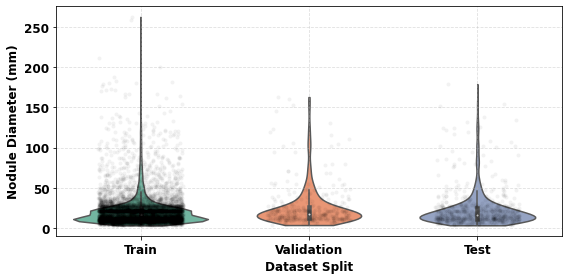

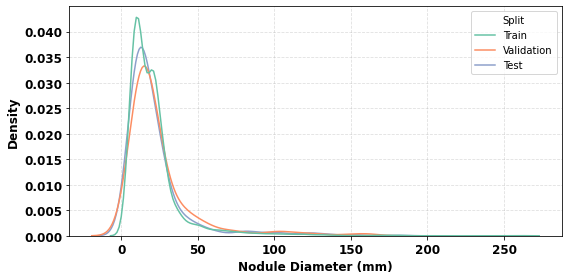

In [65]:
# === Final Code: Radiology-Style Nodule Summary Table ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load bounding box metadata
df = pd.read_csv("filtered_unitochest_bounding_boxes_annotations_metadata.csv")

# Compute nodule diameter
df["diameter_mm"] = np.sqrt(df["w"]**2 + df["h"]**2 + df["d"]**2)

# Summary statistics per split
summary = df.groupby("Split").agg(
    Nodule_Count=("Patient", "count"),
    Mean_Diameter_mm=("diameter_mm", "mean"),
    Median_Diameter_mm=("diameter_mm", "median"),
    Min_Diameter_mm=("diameter_mm", "min"),
    Max_Diameter_mm=("diameter_mm", "max")
).round(2)

# Add total row
total_row = pd.DataFrame({
    "Nodule_Count": [df.shape[0]],
    "Mean_Diameter_mm": [df["diameter_mm"].mean()],
    "Median_Diameter_mm": [df["diameter_mm"].median()],
    "Min_Diameter_mm": [df["diameter_mm"].min()],
    "Max_Diameter_mm": [df["diameter_mm"].max()]
}, index=["Total"]).round(2)

summary_full = pd.concat([summary, total_row])

# Format mean ± SD
mean_sd_series = df.groupby("Split")["diameter_mm"].agg(lambda x: f"{x.mean():.1f} ± {x.std():.1f}")
mean_sd_series["Total"] = f"{df['diameter_mm'].mean():.1f} ± {df['diameter_mm'].std():.1f}"

# Apply formatted column
summary_full["Mean ± SD (mm)"] = mean_sd_series

# Reorder and rename columns
final_table = summary_full[[
    "Nodule_Count",
    "Mean ± SD (mm)",
    "Median_Diameter_mm",
    "Min_Diameter_mm",
    "Max_Diameter_mm"
]].rename(columns={
    "Nodule_Count": "Nodule Count",
    "Median_Diameter_mm": "Median (mm)",
    "Min_Diameter_mm": "Min (mm)",
    "Max_Diameter_mm": "Max (mm)"
})

# Display the table
from tabulate import tabulate
print(tabulate(final_table, headers="keys", tablefmt="grid"))

# === Violin Plot with Dots for Nodule Diameter ===
plt.figure(figsize=(8, 4))
sns.violinplot(data=df, x="Split", y="diameter_mm", inner="box", palette="Set2", cut=0,order=["Train", "Validation", "Test"])
sns.stripplot(data=df, x="Split", y="diameter_mm", color="black", alpha=0.05, jitter=0.25, size=4, edgecolor='red',order=["Train", "Validation", "Test"])
#plt.title("Nodule Diameter Distribution by Split", fontsize=14, fontweight="bold")
plt.xlabel("Dataset Split",        fontsize=12, fontweight="bold")
plt.ylabel("Nodule Diameter (mm)", fontsize=12, fontweight="bold")
plt.xticks(fontsize=12, fontweight="bold")
plt.yticks(fontsize=12, fontweight="bold")
plt.grid(True, linestyle="--", alpha=0.4)
plt.tight_layout()
plt.savefig("nodule_diameter_distribution_by_split.png", dpi=300)
plt.show()

# === KDE Plot of Nodule Diameters ===
plt.figure(figsize=(8, 4))
sns.kdeplot(data=df, x="diameter_mm", hue="Split", common_norm=False, fill=False, palette="Set2", alpha=1,hue_order=["Train", "Validation", "Test"])
#plt.title("KDE of Nodule Diameters by Split", fontsize=14, fontweight="bold")
plt.xlabel("Nodule Diameter (mm)", fontsize=12, fontweight="bold")
plt.ylabel("Density", fontsize=12, fontweight="bold")
plt.xticks(fontsize=12, fontweight="bold")
plt.yticks(fontsize=12, fontweight="bold")
plt.grid(True, linestyle="--", alpha=0.4)
plt.tight_layout()
plt.savefig("nodule_diameter_kde_by_split.png", dpi=300)
plt.show()



# Daignostic-Nodule Patches

In [8]:
import pandas as pd
CADe_df = pd.read_csv('filtered_unitochest_bounding_boxes_annotations_metadata.csv')
CADe_df['nifti_name'] = CADe_df['Patient']

def assign_annotation_ids(group):
    group['annotation-idx'] = [f"{str(i+1).zfill(2)}" for i in range(len(group))]
    return group

CADe_df                            = CADe_df.groupby('nifti_name').apply(assign_annotation_ids)
CADe_df['UNIQUE_ANNOTATION_ID']    = CADe_df['nifti_name'].str.split('.nii.gz').str[0]+'_'+CADe_df['annotation-idx']
CADe_df['UNIQUE_ANNOTATION_ID_nifti'] = CADe_df['UNIQUE_ANNOTATION_ID']+'.nii.gz'
CADe_df.to_csv('filtered_unitochest_bounding_boxes_annotations_metadata_nifty_name_lesionIdX.csv',index=False,encoding='utf-8')
CADe_df.to_csv('/NAS/shared_data/for_VNLST/ft42/ct_public/unitochest/unitochest_nifti_ct_resampled_diagnostic_64Q_patches/filtered_unitochest_bounding_boxes_annotations_metadata_nifty_name_lesionIdX.csv',index=False,encoding='utf-8')


/tmp/ipykernel_1927724/1988160568.py:9: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  CADe_df                            = CADe_df.groupby('nifti_name').apply(assign_annotation_ids)


In [7]:
CADe_df

,Patient,ct_path,seg_path,coordX,coordY,coordZ,w,h,d,patientID,...,WindowWidth,RescaleIntercept,RescaleSlope,SoftwareVersions,Split,PatientAgeYears,nifti_name,annotation-idx,UNIQUE_ANNOTATION_ID,UNIQUE_ANNOTATION_ID_nifti
0,unitochestPT1002_exam1_0000.nii.gz,unitochest_nifti_ct/unitochestPT1002_exam1_000...,unitochest_nifti_mask/unitochestPT1002_exam1_m...,93.164062,206.250000,206.00,2.343750,2.929688,10.00,1002,...,"[01900, 01900]",-1024.0,1.0,2.3.0,Validation,69,unitochestPT1002_exam1_0000.nii.gz,01,unitochestPT1002_exam1_0000_01,unitochestPT1002_exam1_0000_01.nii.gz
1,unitochestPT1002_exam1_0000.nii.gz,unitochest_nifti_ct/unitochestPT1002_exam1_000...,unitochest_nifti_mask/unitochestPT1002_exam1_m...,74.414062,79.101562,380.00,5.859375,5.859375,16.00,1002,...,"[01900, 01900]",-1024.0,1.0,2.3.0,Validation,69,unitochestPT1002_exam1_0000.nii.gz,02,unitochestPT1002_exam1_0000_02,unitochestPT1002_exam1_0000_02.nii.gz
2,unitochestPT1002_exam1_0000.nii.gz,unitochest_nifti_ct/unitochestPT1002_exam1_000...,unitochest_nifti_mask/unitochestPT1002_exam1_m...,73.242188,75.585938,386.00,1.171875,1.757812,4.00,1002,...,"[01900, 01900]",-1024.0,1.0,2.3.0,Validation,69,unitochestPT1002_exam1_0000.nii.gz,03,unitochestPT1002_exam1_0000_03,unitochestPT1002_exam1_0000_03.nii.gz
3,unitochestPT1002_exam1_0000.nii.gz,unitochest_nifti_ct/unitochestPT1002_exam1_000...,unitochest_nifti_mask/unitochestPT1002_exam1_m...,94.921875,87.890625,392.00,4.101562,4.687500,14.00,1002,...,"[01900, 01900]",-1024.0,1.0,2.3.0,Validation,69,unitochestPT1002_exam1_0000.nii.gz,04,unitochestPT1002_exam1_0000_04,unitochestPT1002_exam1_0000_04.nii.gz
4,unitochestPT1009_exam1_0000.nii.gz,unitochest_nifti_ct/unitochestPT1009_exam1_000...,unitochest_nifti_mask/unitochestPT1009_exam1_m...,88.720662,159.697192,151.25,14.658196,16.972648,15.00,1009,...,400,-1024.0,1.0,vct_zeta.4,Train,76,unitochestPT1009_exam1_0000.nii.gz,01,unitochestPT1009_exam1_0000_01,unitochestPT1009_exam1_0000_01.nii.gz
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8316,unitochestPT997_exam2_0000.nii.gz,unitochest_nifti_ct/unitochestPT997_exam2_0000...,unitochest_nifti_mask/unitochestPT997_exam2_ma...,89.619141,197.162109,230.00,5.455078,5.455078,25.00,997,...,"[00400, 00400]",-1024.0,1.0,2.3.0,Train,69,unitochestPT997_exam2_0000.nii.gz,84,unitochestPT997_exam2_0000_84,unitochestPT997_exam2_0000_84.nii.gz
8317,unitochestPT997_exam2_0000.nii.gz,unitochest_nifti_ct/unitochestPT997_exam2_0000...,unitochest_nifti_mask/unitochestPT997_exam2_ma...,110.660156,267.298828,225.00,6.234375,7.013672,20.00,997,...,"[00400, 00400]",-1024.0,1.0,2.3.0,Train,69,unitochestPT997_exam2_0000.nii.gz,85,unitochestPT997_exam2_0000_85,unitochestPT997_exam2_0000_85.nii.gz
8318,unitochestPT997_exam2_0000.nii.gz,unitochest_nifti_ct/unitochestPT997_exam2_0000...,unitochest_nifti_mask/unitochestPT997_exam2_ma...,128.583984,282.105469,230.00,4.675781,4.675781,20.00,997,...,"[00400, 00400]",-1024.0,1.0,2.3.0,Train,69,unitochestPT997_exam2_0000.nii.gz,86,unitochestPT997_exam2_0000_86,unitochestPT997_exam2_0000_86.nii.gz
8319,unitochestPT999_exam1_0000.nii.gz,unitochest_nifti_ct/unitochestPT999_exam1_0000...,unitochest_nifti_mask/unitochestPT999_exam1_ma...,95.156317,250.125175,143.75,14.953135,13.593760,13.75,999,...,1600,-1024.0,1.0,cj3_6m3a_qr.11,Train,84,unitochestPT999_exam1_0000.nii.gz,01,unitochestPT999_exam1_0000_01,unitochestPT999_exam1_0000_01.nii.gz
